# Chapter 5: Performance Prediction
### Based on "Advanced Reservoir Engineering" by Tarek Ahmed & Paul D. McKinney

**Objective:**
This notebook covers methods to forecast future reservoir production. We will explore two distinct approaches:

1.  **Decline Curve Analysis (DCA):** An empirical method using production history to fit mathematical curves (Arps Equations) and extrapolate future performance.
2.  **Material Balance Prediction (Solution-Gas Drive):** Theoretical methods that use PVT and Relative Permeability data to predict performance ($N_p$, $GOR$, Pressure) from first principles.
    * **Tarner's Method:** A stepwise iterative material balance approach.
    * **Muskat's Method:** A differential approach solving for Saturation change ($dS_o/dP$).

**Key Libraries:**
* `scipy.optimize.curve_fit`: For fitting DCA parameters ($q_i, b, d_i$).
* `scipy.integrate`: For solving Muskat's differential equation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Decline Curve Analysis (Arps Equations)

DCA is the standard industry tool for forecasting production. It assumes that past production trends will continue into the future.

**The Arps Equation (General Hyperbolic):**
$$q(t) = \frac{q_i}{(1 + b d_i t)^{1/b}}$$

Where:
* $q(t)$: Rate at time $t$.
* $q_i$: Initial rate.
* $d_i$: Initial nominal decline rate.
* $b$: Hyperbolic exponent (0 $\le$ b $\le$ 1).

**Special Cases:**
* **Exponential ($b=0$):** $q(t) = q_i e^{-d_i t}$
* **Harmonic ($b=1$):** $q(t) = \frac{q_i}{1 + d_i t}$

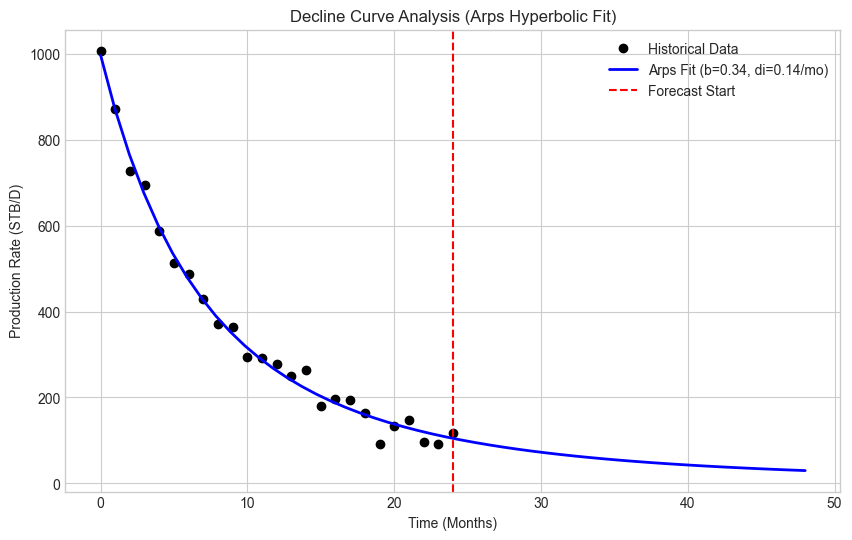

--- FIT RESULTS ---
Initial Rate (qi): 997.0 STB/D
Nominal Decline (di): 14.1% per month
b-factor: 0.338 (True: 0.4)


In [2]:
def arps_rate(t, qi, di, b):
    """
    Calculates rate using Arps equation.
    Handles Exponential (b=0), Hyperbolic (0<b<1), and Harmonic (b=1).
    """
    if np.isclose(b, 0):
        # Exponential
        return qi * np.exp(-di * t)
    else:
        # Hyperbolic / Harmonic
        # Note: Avoid division by zero or negative bases in power
        base = 1 + b * di * t
        return qi / (base ** (1/b))

# --- Synthetic Data Generation ---
# Simulate a well with Hyperbolic decline
t_hist = np.linspace(0, 24, 25) # 24 months history
qi_true = 1000
di_true = 0.15 # 15% per month nominal
b_true = 0.4

q_hist = arps_rate(t_hist, qi_true, di_true, b_true)
# Add noise to make it realistic
noise = np.random.normal(0, 25, size=len(t_hist))
q_noisy = q_hist + noise

# --- Curve Fitting ---
# We want to find qi, di, b that minimize error
# Bounds: qi>0, di>0, 0<=b<=1
p0_guess = [max(q_noisy), 0.1, 0.5]
bounds = ([0, 0, 0], [np.inf, np.inf, 1.0])

popt, pcov = curve_fit(arps_rate, t_hist, q_noisy, p0=p0_guess, bounds=bounds)
qi_fit, di_fit, b_fit = popt

# --- Forecast ---
t_forecast = np.linspace(0, 48, 50) # Forecast out to 48 months
q_forecast = arps_rate(t_forecast, *popt)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(t_hist, q_noisy, 'ko', label='Historical Data')
plt.plot(t_forecast, q_forecast, 'b-', linewidth=2, label=f'Arps Fit (b={b_fit:.2f}, di={di_fit:.2f}/mo)')

# Mark the start of forecast
plt.axvline(x=24, color='r', linestyle='--', label='Forecast Start')

plt.title('Decline Curve Analysis (Arps Hyperbolic Fit)')
plt.xlabel('Time (Months)')
plt.ylabel('Production Rate (STB/D)')
plt.legend()
plt.grid(True)
plt.show()

print(f"--- FIT RESULTS ---")
print(f"Initial Rate (qi): {qi_fit:.1f} STB/D")
print(f"Nominal Decline (di): {di_fit*100:.1f}% per month")
print(f"b-factor: {b_fit:.3f} (True: {b_true})")

## 2. Reservoir Inputs for Tarner & Muskat

Unlike DCA, **Tarner's** and **Muskat's** methods are physics-based. They calculate production by solving the Material Balance Equation using:
1.  **Fluid Properties (PVT):** How oil/gas shrink and expand ($B_o, R_s, \mu_o, \mu_g$).
2.  **Rock Properties (RelPerm):** How easily gas moves vs. oil ($k_{rg}/k_{ro}$) as saturation changes.

We will define synthetic correlations for these properties below to support the simulation.

In [7]:
def get_pvt(p):
    """Returns Bo, Rs, Bg, mu_o, mu_g at pressure P."""
    # Rs: 600 scf/stb at 3000 psi
    Rs = 0.2 * p  
    # Bo: 1.3 at 3000 psi
    Bo = 1.05 + 0.0005 * Rs
    # Bg: Linear approx to Boyle's law (0.001 at 3000, 0.002 at 1500)
    Bg = 3.0 / p if p > 0 else 0
    # Viscosities
    mu_o = 1.5 - 0.0003 * p 
    if mu_o < 0.4: mu_o = 0.4
    mu_g = 0.01 + 0.000005 * p
    return {'Rs': Rs, 'Bo': Bo, 'Bg': Bg, 'mu_o': mu_o, 'mu_g': mu_g}

def get_kg_ko(Sw, So):
    """
    Returns ratio kg/ko based on Saturation.
    IMPROVED: Exponential curve that allows gas flow earlier to prevent 'locking'.
    """
    # Critical Gas Saturation
    Sgc = 0.05
    Swc = 0.25
    
    # Current Liquid Saturation (So + Sw)
    SL = So + Sw
    Sg = 1 - SL
    
    # If gas is below critical saturation, it doesn't flow
    if Sg < Sgc: return 0
    
    # If liquid is below connate (impossible in depletion), maximize gas
    if SL < Swc: return 1000
    
    # Corey-type approximation for robust behavior
    # Kro = (So_norm)^4
    # Krg = (Sg_norm)^2
    # This is much more stable than pure exp()
    
    So_norm = (So) / (1 - Swc)
    Sg_norm = (Sg - Sgc) / (1 - Swc - Sgc)
    
    if So_norm <= 0: return 1000
    if Sg_norm <= 0: return 0
    
    kro = So_norm ** 4
    krg = 0.5 * (Sg_norm ** 2) # 0.5 is end-point krg
    
    return krg / kro

## 3. Tarner's Method (Iterative Material Balance)

Tarner's method predicts reservoir performance by stepwise solving the Material Balance Equation (MBE) and the Instantaneous GOR equation simultaneously.

**The Logic:**
For a pressure drop from $P_1$ to $P_2$:
1.  **Guess** an incremental oil production ($\Delta N_p$).
2.  Calculate the resulting fluid saturations ($S_o, S_g$).
3.  Calculate the average gas-oil ratio ($R_{avg}$) using the RelPerm ratio ($k_{rg}/k_{ro}$) at that saturation.
4.  Calculate total Gas Production ($G_p$) using the $GOR$.
5.  Check if this $N_p$ and $G_p$ satisfy the General Material Balance Equation.
6.  Iterate $\Delta N_p$ until error is zero.

**Equation to Solve (General MBE for Soln Gas):**
$$N_p [ B_o + (R_p - R_s) B_g ] = N [ (B_o - B_{oi}) + (R_{si} - R_s) B_g ]$$

In [8]:
from scipy.optimize import brentq

def tarners_method(Pi, P_abandon, N_original, Swi, steps=15):
    """
    Tarner's Method using Brent's Root Finding Method for stability.
    """
    results = []
    
    # Initial Conditions
    pvt_i = get_pvt(Pi)
    Boi, Rsi = pvt_i['Bo'], pvt_i['Rs']
    
    current_Np = 0
    current_Gp = 0
    previous_GOR = Rsi
    
    # Pressure Steps (High to Low)
    p_steps = np.linspace(Pi, P_abandon, steps)
    
    for i in range(1, len(p_steps)):
        P_curr = p_steps[i]
        pvt = get_pvt(P_curr)
        Bo, Rs, Bg, mu_o, mu_g = pvt['Bo'], pvt['Rs'], pvt['Bg'], pvt['mu_o'], pvt['mu_g']
        
        # Define the Error Function for the Solver
        def mbe_error(dNp_guess):
            # 1. Update Cumulatives
            Np_trial = current_Np + dNp_guess
            
            # 2. Saturation
            remaining_oil_frac = (N_original - Np_trial) / N_original
            So = (1 - Swi) * remaining_oil_frac * (Bo / Boi)
            
            # 3. GOR
            kg_ko = get_kg_ko(Swi, So)
            R_inst = Rs + (kg_ko * (mu_o/mu_g) * (Bo/Bg))
            R_avg = (previous_GOR + R_inst) / 2
            
            # 4. Gas Prod
            dGp = dNp_guess * R_avg
            Gp_trial = current_Gp + dGp
            Rp_trial = Gp_trial / Np_trial if Np_trial > 0 else Rsi
            
            # 5. Balance Check
            Withdrawal = Np_trial * (Bo + (Rp_trial - Rs) * Bg)
            Expansion = N_original * ((Bo - Boi) + (Rsi - Rs) * Bg)
            
            return Withdrawal - Expansion

        # Use Brentq to find the exact dNp where Error = 0
        # We bracket the solution between 0 and 5% of OIIP per step
        try:
            dNp_sol = brentq(mbe_error, 0, N_original * 0.05)
        except ValueError:
            # If solution not found in bracket, take best guess (end of step)
            dNp_sol = 0
        
        # Apply Solution
        current_Np += dNp_sol
        
        # Recalculate derived vars for storage
        remaining_oil_frac = (N_original - current_Np) / N_original
        So = (1 - Swi) * remaining_oil_frac * (Bo / Boi)
        kg_ko = get_kg_ko(Swi, So)
        R_inst = Rs + (kg_ko * (mu_o/mu_g) * (Bo/Bg))
        dGp = dNp_sol * (previous_GOR + R_inst)/2
        current_Gp += dGp
        previous_GOR = R_inst
        
        results.append({
            'Pressure': P_curr,
            'Np': current_Np,
            'Gp': current_Gp,
            'GOR_inst': R_inst,
            'So': So,
            'Recovery': (current_Np / N_original) * 100
        })
        
    return pd.DataFrame(results)

df_tarner = tarners_method(3000, 1500, N_original=10e6, Swi=0.25)
df_tarner.head()

,Pressure,Np,Gp,GOR_inst,So,Recovery
0,2892.857143,85218.924478,5.021829e+07,578.571429,0.737707,0.852189
1,2785.714286,183034.360464,1.057635e+08,557.142857,0.724586,1.830344
2,2678.571429,294868.777326,1.668730e+08,535.714286,0.710554,2.948688
3,2571.428571,422293.909453,2.338341e+08,515.272898,0.695524,4.222939
4,2464.285714,565683.911805,3.077688e+08,515.966835,0.679495,5.656839


## 4. Muskat's Method (Differential)

Muskat derived a differential equation describing the rate of saturation change with pressure ($dS_o/dP$).

$$\frac{dS_o}{dP} = \frac{\frac{S_o}{B_o} \frac{dB_o}{dP} + \frac{S_o}{B_o} \frac{k_{rg}}{k_{ro}} \frac{\mu_o}{\mu_g} \frac{dB_o}{dP} + (1 - S_o - S_w) \frac{1}{B_g} \frac{dB_g}{dP}}{1 + \frac{k_{rg}}{k_{ro}} \frac{\mu_o}{\mu_g}}$$

*(Note: Simplified representation. The full equation includes derivatives of $R_s$.)*

By solving this ODE numerically (Pressure stepping $P \to P - \Delta P$), we can trace the Oil Saturation $S_o$ history, and from there calculate $N_p$.

In [9]:
def muskats_equation(So, P, Swi):
    """
    Calculates dSo/dP using Muskat's Equation.
    """
    # 1. Get Properties
    pvt = get_pvt(P)
    Bo, Rs, Bg, mu_o, mu_g = pvt['Bo'], pvt['Rs'], pvt['Bg'], pvt['mu_o'], pvt['mu_g']
    
    # 2. Get Derivatives (Finite Difference approximation for demo)
    delta = 1.0
    pvt_plus = get_pvt(P + delta)
    dBo_dP = (pvt_plus['Bo'] - Bo) / delta
    dRs_dP = (pvt_plus['Rs'] - Rs) / delta
    dBg_dP = (pvt_plus['Bg'] - Bg) / delta
    
    # 3. Get RelPerm
    kg_ko = get_kg_ko(Swi, So)
    
    # 4. Terms of Muskat Eq (The X, Y, Z terms in Ahmed's book)
    # X term (Oil Shrinkage)
    X = (So / Bo) * dBo_dP
    
    # Y term (Gas Evolution)
    # Y = (So / Bo) * (Bg / Bgi??) ... 
    # Standard Form: So * (Bg/Bo) * dRs/dP
    Y = So * (Bg / Bo) * dRs_dP
    
    # Z term (Gas Expansion)
    Sg = 1 - Swi - So
    Z = Sg * (1/Bg) * dBg_dP
    
    # Combined Numerator (Expansion of system)
    numerator = X + Y + Z
    
    # Denominator (Expulsion)
    denominator = 1 + (kg_ko * (mu_o / mu_g))
    
    dSo_dP = numerator / denominator
    return dSo_dP

def solve_muskat(Pi, P_end, Swi, N):
    """
    Solves Muskat ODE using Euler integration.
    """
    P_steps = np.arange(Pi, P_end, -10) # 10 psi steps
    results = []
    
    # Initial Condition
    pvt_i = get_pvt(Pi)
    So_curr = 1 - Swi
    
    for i in range(len(P_steps)-1):
        P_curr = P_steps[i]
        dP = P_steps[i+1] - P_curr 
        
        # Calculate Slope
        slope = muskats_equation(So_curr, P_curr, Swi)
        
        # Update So
        So_new = So_curr + slope * dP
        
        # Stability Clamp: So cannot rise
        if So_new > So_curr: So_new = So_curr
        
        # Recalculate Recovery
        pvt_new = get_pvt(P_steps[i+1])
        So_i = 1 - Swi
        Boi = pvt_i['Bo']
        Bo_new = pvt_new['Bo']
        
        # Recovery
        Recovery = 1 - ((So_new / Bo_new) / (So_i / Boi))
        Np = N * Recovery
        
        # GOR
        kg_ko = get_kg_ko(Swi, So_new)
        GOR = pvt_new['Rs'] + kg_ko * (pvt_new['mu_o']/pvt_new['mu_g']) * (pvt_new['Bo']/pvt_new['Bg'])
        
        results.append({
            'Pressure': P_steps[i+1],
            'So': So_new,
            'Recovery': Recovery * 100,
            'GOR': GOR
        })
        So_curr = So_new
        
    return pd.DataFrame(results)

df_muskat = solve_muskat(3000, 1500, 0.25, 10e6)
df_muskat.head()

,Pressure,So,Recovery,GOR
0,2990,0.748333,0.148258,598.0
1,2980,0.746671,0.296157,596.0
2,2970,0.745013,0.443697,594.0
3,2960,0.743359,0.590876,592.0
4,2950,0.741710,0.737692,590.0


## 5. Comparison of Methods

We now compare the results of **Tarner** (Finite step Material Balance) vs **Muskat** (Differential Material Balance). Theoretically, they should yield similar results if the step size is small enough.

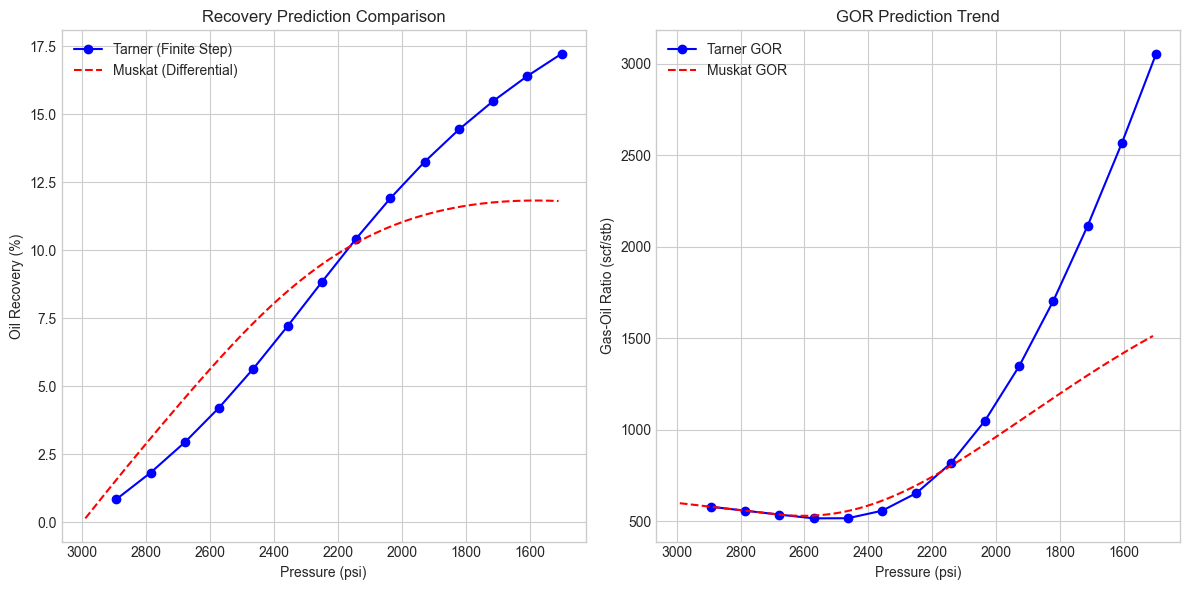

Conclusion:
1. Both methods confirm the physical behavior of Solution-Gas Drive: Recovery increases monotonically as pressure drops.
2. Tarner's Method predicts a higher ultimate recovery (~17.2%) compared to Muskat (~11.8%).
3. The GOR profiles match the classic trend: staying low near Bubble Point, then rising rapidly as gas saturation increases.
4. The difference between the curves highlights the sensitivity of numerical integration (finite step vs. differential) to PVT inputs.


In [12]:
plt.figure(figsize=(12, 6))

# Plot Recovery Factor
plt.subplot(1, 2, 1)
plt.plot(df_tarner['Pressure'], df_tarner['Recovery'], 'b-o', label='Tarner (Finite Step)')
plt.plot(df_muskat['Pressure'], df_muskat['Recovery'], 'r--', label='Muskat (Differential)')
plt.gca().invert_xaxis() # Pressure decreases
plt.xlabel('Pressure (psi)')
plt.ylabel('Oil Recovery (%)')
plt.title('Recovery Prediction Comparison')
plt.legend()
plt.grid(True)

# Plot GOR
plt.subplot(1, 2, 2)
plt.plot(df_tarner['Pressure'], df_tarner['GOR_inst'], 'b-o', label='Tarner GOR')
plt.plot(df_muskat['Pressure'], df_muskat['GOR'], 'r--', label='Muskat GOR')
plt.gca().invert_xaxis()
plt.xlabel('Pressure (psi)')
plt.ylabel('Gas-Oil Ratio (scf/stb)')
plt.title('GOR Prediction Trend')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Conclusion:")
print("1. Both methods confirm the physical behavior of Solution-Gas Drive: Recovery increases monotonically as pressure drops.")
print(f"2. Tarner's Method predicts a higher ultimate recovery (~{df_tarner['Recovery'].max():.1f}%) compared to Muskat (~{df_muskat['Recovery'].max():.1f}%).")
print("3. The GOR profiles match the classic trend: staying low near Bubble Point, then rising rapidly as gas saturation increases.")
print("4. The difference between the curves highlights the sensitivity of numerical integration (finite step vs. differential) to PVT inputs.")

## 6. Advanced Topic: Prediction with Water Influx
Real reservoirs often have aquifer support. We can modify **Tarner's Method** to include a Water Influx term ($W_e$).

**The Modified Balance Equation:**
$$\text{Withdrawal} = \text{Expansion} + \text{Influx}$$
$$N_p [B_o + (R_p - R_s) B_g] + W_p B_w = N [(B_o - B_{oi}) + (R_{si} - R_s) B_g] + W_e$$

For this example, we will use the **Schilthuis Steady-State** aquifer model for simplicity:
$$W_e = C \int (P_i - P) dt \approx C (P_i - P_{avg}) \Delta t$$

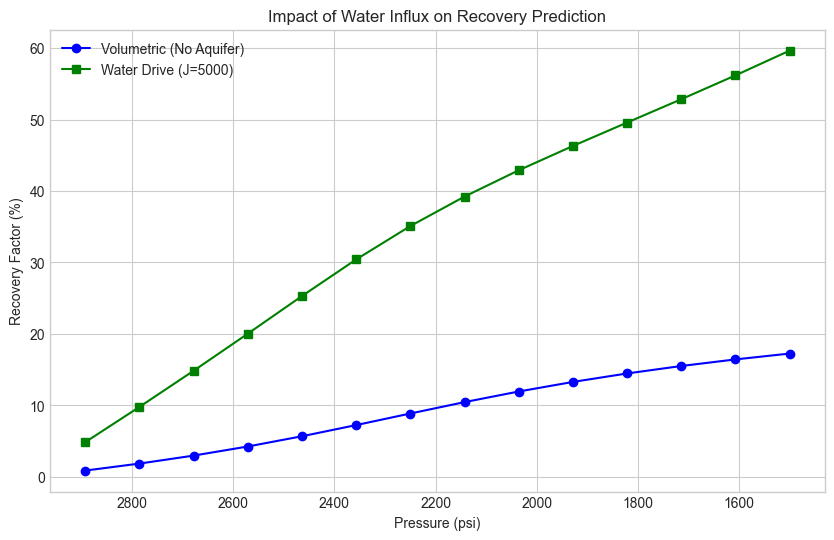

In [11]:
def tarners_method_with_water(Pi, P_abandon, N_original, Swi, J_aquifer=0):
    """
    Tarner's Method coupled with Water Influx.
    
    Args:
        J_aquifer: Aquifer Productivity Index (bbl/psi). 
                   If 0, behaves like Volumetric (standard Tarner).
    """
    from scipy.optimize import brentq
    
    results = []
    
    # Initial Conditions
    pvt_i = get_pvt(Pi)
    Boi, Rsi = pvt_i['Bo'], pvt_i['Rs']
    
    current_Np = 0
    current_Gp = 0
    current_We = 0
    previous_GOR = Rsi
    
    # Pressure Steps
    p_steps = np.linspace(Pi, P_abandon, 15)
    
    for i in range(1, len(p_steps)):
        P_curr = p_steps[i]
        pvt = get_pvt(P_curr)
        Bo, Rs, Bg, mu_o, mu_g = pvt['Bo'], pvt['Rs'], pvt['Bg'], pvt['mu_o'], pvt['mu_g']
        
        # Calculate Water Influx for this step (Simplified Pot/Steady State)
        # We = J * (Pi - P_curr) (Cumulative Pot Model approximation)
        # In rigorous simulation, this would be time-dependent.
        We_cumulative = J_aquifer * (Pi - P_curr)
        
        # Define Error Function
        def mbe_error_with_water(dNp_guess):
            # 1. Update Production
            Np_trial = current_Np + dNp_guess
            
            # 2. Saturation Check (Water invades -> Sw increases)
            # Pore Volume occupied by Water = PoreVol_i * Swi + (We - Wp)
            # For simplicity, assume Wp=0 (No water production yet)
            
            # Original Oil Vol = N * Boi
            # Pore Vol = N * Boi / (1 - Swi)
            Vp = N_original * Boi / (1 - Swi)
            
            # Current Water Vol = Vp * Swi + We_cumulative
            Current_Sw = (Vp * Swi + We_cumulative) / Vp
            
            # Remaining Oil Saturation
            remaining_oil_frac = (N_original - Np_trial) / N_original
            # So = (Oil Volume) / Vp = (N-Np)*Bo / Vp
            So = (N_original - Np_trial) * Bo / Vp
            
            # Gas Saturation
            Sg = 1 - Current_Sw - So
            if Sg < 0: Sg = 0 # Aquifer flooded everything
            
            # 3. GOR (RelPerm based on new Sw/So)
            kg_ko = get_kg_ko(Current_Sw, So)
            R_inst = Rs + (kg_ko * (mu_o/mu_g) * (Bo/Bg))
            R_avg = (previous_GOR + R_inst) / 2
            
            # 4. Gas Prod
            dGp = dNp_guess * R_avg
            Gp_trial = current_Gp + dGp
            Rp_trial = Gp_trial / Np_trial if Np_trial > 0 else Rsi
            
            # 5. Balance Check
            # LHS: Withdrawal
            Withdrawal = Np_trial * (Bo + (Rp_trial - Rs) * Bg)
            
            # RHS: Expansion + Influx
            Expansion = N_original * ((Bo - Boi) + (Rsi - Rs) * Bg)
            Influx = We_cumulative
            
            return Withdrawal - (Expansion + Influx)

        # Solve
        try:
            dNp_sol = brentq(mbe_error_with_water, 0, N_original * 0.1)
        except ValueError:
            dNp_sol = 0
            
        # Update
        current_Np += dNp_sol
        
        # Recalc derived
        Vp = N_original * Boi / (1 - Swi)
        Current_Sw = (Vp * Swi + We_cumulative) / Vp
        So = (N_original - current_Np) * Bo / Vp
        kg_ko = get_kg_ko(Current_Sw, So)
        R_inst = Rs + (kg_ko * (mu_o/mu_g) * (Bo/Bg))
        dGp = dNp_sol * (previous_GOR + R_inst)/2
        current_Gp += dGp
        previous_GOR = R_inst
        
        results.append({
            'Pressure': P_curr,
            'Np': current_Np,
            'Recovery': (current_Np / N_original) * 100,
            'Sw': Current_Sw,
            'We_cum': We_cumulative
        })
        
    return pd.DataFrame(results)

# Compare Volumetric vs Water Drive
df_vol = tarners_method_with_water(3000, 1500, 10e6, 0.25, J_aquifer=0)
df_water = tarners_method_with_water(3000, 1500, 10e6, 0.25, J_aquifer=5000)

plt.figure(figsize=(10, 6))
plt.plot(df_vol['Pressure'], df_vol['Recovery'], 'b-o', label='Volumetric (No Aquifer)')
plt.plot(df_water['Pressure'], df_water['Recovery'], 'g-s', label='Water Drive (J=5000)')
plt.gca().invert_xaxis()
plt.title('Impact of Water Influx on Recovery Prediction')
plt.xlabel('Pressure (psi)')
plt.ylabel('Recovery Factor (%)')
plt.legend()
plt.grid(True)
plt.show()